## VISUALIZE RESULTS

### Load Packages

In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Load Model

In [5]:
from keras.models import load_model
model = load_model('RFGR_LSTM_S1000_E25_V150.hdf5')

In [6]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.input.shape[2]

4

## Config NN_Data Model

### (Check if NN Data is suitable for NN Model)


### SET TIME SERIES DATA

In [8]:
lookback = 3*24*7  # no. of hours to use to forecast next hour
step = 1  # 1 for 1 hour, 24 for 1 day, etc.
delay = 1  # no. of hour(s) ahead to forecast
batch_size = 64  # no. of records per epoch, 
# each record contains "lookback" hours of input and "delay" hours of output,
# 2 ^ n batch_size, i.e. 2,4,8,16

In [9]:
lookback

504

In [10]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile model (required to make predictions)
model.compile(optimizer=RMSprop(), loss='mae')
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [12]:
import os
fname = 'Hourly Demand_201301-201906_ALL_PH_MOD.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:len(lines)-1]
print(header)
print(len(lines))
# print(lines)

['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH']
56928


In [13]:
selected_columns = ['MONTH', 'WEEKDAY', ' HR ', 'PH']

In [14]:
import pandas as pd

data2 = pd.read_csv('Hourly Demand_201301-201906_ALL_PH_MOD.csv',
                    usecols=selected_columns)
dummy = data2
dummy.head()

,MONTH,WEEKDAY,HR,PH
0,1,2,1,6331
1,1,2,2,5702
2,1,2,3,5373
3,1,2,4,5121
4,1,2,5,5029


In [15]:
len(lines), len(header)

(56928, 5)

In [16]:
import os
fname = 'Hourly Demand_201301-201906_ALL_PH_MOD.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:len(lines)-1]
print(header)
print(len(lines))
# print(lines)

['DUMMY_TO_DELETE', 'MONTH', 'WEEKDAY', ' HR ', 'PH']
56928


In [17]:
len(lines), len(header)

(56928, 5)

In [18]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [19]:
float_data

array([[1.0000e+00, 2.0000e+00, 1.0000e+00, 6.3310e+03],
       [1.0000e+00, 2.0000e+00, 2.0000e+00, 5.7020e+03],
       [1.0000e+00, 2.0000e+00, 3.0000e+00, 5.3730e+03],
       ...,
       [6.0000e+00, 7.0000e+00, 2.2000e+01, 1.1315e+04],
       [6.0000e+00, 7.0000e+00, 2.3000e+01, 1.0668e+04],
       [6.0000e+00, 7.0000e+00, 2.4000e+01, 1.0101e+04]])

In [20]:
NN_data = float_data

In [21]:
train_count = int(len(NN_data)*.7)
validate_count = int((len(NN_data)-train_count)*0.5)
test_count = len(NN_data)-train_count-validate_count

train_count, validate_count, test_count

(39849, 8539, 8540)

In [22]:
mean = NN_data[:train_count].mean(axis=0)
NN_data -= mean
std = NN_data[:train_count].std(axis=0)
NN_data /= std

In [23]:
NN_data

array([[-1.52188013, -0.9993697 , -1.6610214 , -1.59968355],
       [-1.52188013, -0.9993697 , -1.51656348, -1.98956918],
       [-1.52188013, -0.9993697 , -1.37210556, -2.19349982],
       ...,
       [-0.0584152 ,  1.5008427 ,  1.37259495,  1.4896487 ],
       [-0.0584152 ,  1.5008427 ,  1.51705287,  1.08860577],
       [-0.0584152 ,  1.5008427 ,  1.66151079,  0.73715083]])

In [24]:
mean, std

(array([6.19957841e+00, 3.99856960e+00, 1.24983061e+01, 8.91175927e+03]),
 array([   3.41654924,    1.99983009,    6.92243105, 1613.29361826]))

### Define Target Column

In [25]:
dummy.columns

Index(['MONTH', 'WEEKDAY', ' HR ', 'PH'], dtype='object')

In [26]:
target_column = len(dummy.columns)-1

In [27]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, 
              batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_column]
        yield samples, targets

In [28]:
train_gen = generator(NN_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train_count,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(NN_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_count+1,
                    max_index=train_count+validate_count,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(NN_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=train_count+validate_count+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# How many steps to draw from val_gen
# in order to see the entire validation set
val_steps = (validate_count - 1 - lookback)

# How many steps to draw from test_gen in order to see the
# entire test set
test_steps = (test_count - 1 - lookback)

## MAE for Train Data (200 samples)

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
train_count

39849

In [31]:
val_steps, test_steps

(8034, 8035)

In [32]:
j = 0
max_iter = 200  # train_count

mae_results = 0
mae_count = 0
mae_final = 0
y_pred_real_all = []
y_actual_real_all = []

for nn_input, nn_output in train_gen:
    # print(nn_input[0])
    # print(nn_output[0])
    y_pred = model.predict(nn_input)
    y_pred_real = y_pred*std[target_column]+mean[target_column]
    nn_output_real = nn_output*std[target_column]+mean[target_column]
    for i in range(len(nn_output_real)):
        mae_count += 1
        mae_results += abs((y_pred_real[i] -
                            nn_output_real[i])/nn_output_real[i]*100)
        mae_final = mae_results/mae_count
        y_pred_real_all.append(y_pred_real[i])
        y_actual_real_all.append(nn_output_real[i])
#         print(y_pred_real[i], 
#               nn_output_real[i], 
#               (y_pred_real[i]-nn_output_real[i]),
#               abs((y_pred_real[i]-nn_output_real[i])/nn_output_real[i]*100))
#     print(mae_final)
    j += 1
    if j == max_iter:
        break
print("MAE FINAL-TRAIN: ", mae_final)

MAE FINAL-TRAIN:  [0.99774635]


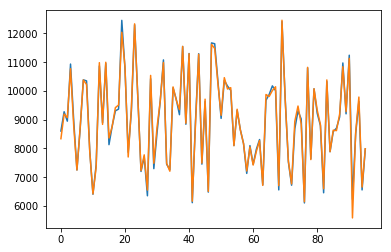

In [33]:
plt.plot(y_pred_real_all[:96])
plt.plot(y_actual_real_all[:96])

**Please note that the above are not consecutive hours.**

## MAE for Validation Data (200 samples)

In [34]:
j = 0
max_iter = 200  # val_steps

mae_results = 0
mae_count = 0
mae_final = 0

for nn_input, nn_output in val_gen:
    # print(nn_input[0])
    # print(nn_output[0])
    y_pred = model.predict(nn_input)
    y_pred_real = y_pred*std[target_column]+mean[target_column]
    nn_output_real = nn_output*std[target_column]+mean[target_column]
    for i in range(len(nn_output_real)):
        mae_count += 1
        mae_results += abs((y_pred_real[i] -
                            nn_output_real[i])/nn_output_real[i]*100)
        mae_final = mae_results/mae_count
#         print(y_pred_real[i],
#               nn_output_real[i],
#               (y_pred_real[i]-nn_output_real[i]),
#               abs((y_pred_real[i]-nn_output_real[i])/nn_output_real[i]*100))
#     print(mae_final)
    j += 1
    if j == max_iter:
        break
print("MAE FINAL-VALIDATION: ", mae_final)

MAE FINAL-VALIDATION:  [1.0777522]


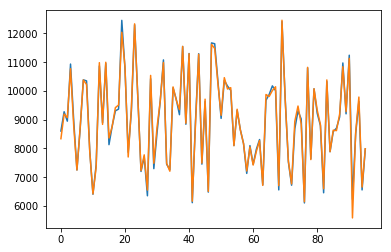

In [35]:
plt.plot(y_pred_real_all[:96])
plt.plot(y_actual_real_all[:96])

**Please note that the above are not consecutive hours.**

## MAE for Test Data (200 samples)

In [36]:
j = 0
max_iter = 200  # test_steps

mae_results = 0
mae_count = 0
mae_final = 0

for nn_input, nn_output in test_gen:
    # print(nn_input[0])
    # print(nn_output[0])
    y_pred = model.predict(nn_input)
    y_pred_real = y_pred*std[target_column]+mean[target_column]
    nn_output_real = nn_output*std[target_column]+mean[target_column]
    for i in range(len(nn_output_real)):
        mae_count += 1
        mae_results += abs((y_pred_real[i] -
                            nn_output_real[i])/nn_output_real[i]*100)
        mae_final = mae_results/mae_count
#         print(y_pred_real[i],
#               nn_output_real[i],
#               (y_pred_real[i]-nn_output_real[i]),
#               abs((y_pred_real[i]-nn_output_real[i])/nn_output_real[i]*100))
#     print(mae_final)
    j += 1
    if j == max_iter:
        break
print("MAE FINAL-TEST: ", mae_final)

MAE FINAL-TEST:  [1.329554]


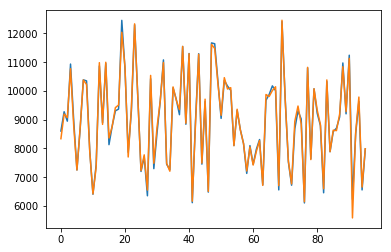

In [37]:
plt.plot(y_pred_real_all[:96])
plt.plot(y_actual_real_all[:96])

#### Please Note that above is not consecutive hours.

# Measure Performance for Consecutive Datapoints

In order to visualize the consecutive hours, the process is described below.

#### Specify number of hours to forecast:

In [40]:
hours_needed = 48

In [41]:
traing = []
for i in range(hours_needed):
    traing.append(next(train_gen))

vg = []
for i in range(hours_needed):
    vg.append(next(val_gen))

testg = []
for i in range(hours_needed):
    testg.append(next(test_gen))

#### Check sanity for each validation dataset

In [42]:
vg[0][1][0:hours_needed]

array([2.47892925, 2.4175641 , 2.65744604, 2.58120449, 2.47644985,
       2.16466531, 1.98180957, 2.3109499 , 2.22417091, 2.02767847,
       1.63469359, 1.17910386, 0.85616203, 0.59768459, 0.3361079 ,
       0.18982331, 0.11048251, 0.26482516, 0.22267536, 0.26420531,
       1.09790351, 1.93036202, 2.3940098 , 2.65434679, 2.54091424,
       2.5068225 , 2.76282053, 2.65124754, 2.4845079 , 2.21239376,
       2.00536387, 2.30041246, 2.23904731, 2.00846312, 1.63159434,
       1.19336041, 0.79789613, 0.57846924, 0.3844562 , 0.18486451,
       0.08444881, 0.27288321, 0.23879146, 0.25862666, 1.10162261,
       1.94399872, 2.42190305, 2.70579434])

In [43]:
# sample_number or batch_size, input_timedelay, number_variables
vg[0][0].shape

(64, 504, 4)

In [44]:
# vg[validation steps][input or target]
vg[23][0].shape

(64, 504, 4)

In [45]:
# target
vg[23][1].shape

(64,)

In [46]:
# total lines with 14 parameters
float_data.shape

(56928, 4)

In [47]:
vg[0][1][0:hours_needed]

array([2.47892925, 2.4175641 , 2.65744604, 2.58120449, 2.47644985,
       2.16466531, 1.98180957, 2.3109499 , 2.22417091, 2.02767847,
       1.63469359, 1.17910386, 0.85616203, 0.59768459, 0.3361079 ,
       0.18982331, 0.11048251, 0.26482516, 0.22267536, 0.26420531,
       1.09790351, 1.93036202, 2.3940098 , 2.65434679, 2.54091424,
       2.5068225 , 2.76282053, 2.65124754, 2.4845079 , 2.21239376,
       2.00536387, 2.30041246, 2.23904731, 2.00846312, 1.63159434,
       1.19336041, 0.79789613, 0.57846924, 0.3844562 , 0.18486451,
       0.08444881, 0.27288321, 0.23879146, 0.25862666, 1.10162261,
       1.94399872, 2.42190305, 2.70579434])

#### Retrieve Mean and Standard Deviation

In [48]:
mean[3]

8911.759266230018

In [49]:
std[3]

1613.2936182600768

#### De-normalize Results (actual MW units)

In [50]:
# prediction for first batch containing batch_size 64
pred1 = model.predict(vg[0][0])

In [51]:
actual_output = vg[0][1][0:hours_needed]*std[3]+mean[3]

In [52]:
predicted_output = pred1[0:hours_needed]*std[3]+mean[3]

In [53]:
actual_output

array([12911., 12812., 13199., 13076., 12907., 12404., 12109., 12640.,
       12500., 12183., 11549., 10814., 10293.,  9876.,  9454.,  9218.,
        9090.,  9339.,  9271.,  9338., 10683., 12026., 12774., 13194.,
       13011., 12956., 13369., 13189., 12920., 12481., 12147., 12623.,
       12524., 12152., 11544., 10837., 10199.,  9845.,  9532.,  9210.,
        9048.,  9352.,  9297.,  9329., 10689., 12048., 12819., 13277.])

In [54]:
predicted_output

array([[12956.075 ],
       [13007.805 ],
       [13335.831 ],
       [13113.547 ],
       [12855.631 ],
       [12330.211 ],
       [12223.224 ],
       [12650.762 ],
       [12314.649 ],
       [12015.917 ],
       [11527.697 ],
       [10955.509 ],
       [10373.993 ],
       [ 9849.169 ],
       [ 9520.46  ],
       [ 9266.24  ],
       [ 9105.652 ],
       [ 9258.16  ],
       [ 9224.361 ],
       [ 9363.758 ],
       [10556.08  ],
       [11976.013 ],
       [12881.922 ],
       [13269.948 ],
       [12976.2705],
       [12966.341 ],
       [13371.005 ],
       [13222.984 ],
       [12987.847 ],
       [12430.919 ],
       [12218.672 ],
       [12666.297 ],
       [12384.64  ],
       [12058.975 ],
       [11559.626 ],
       [10938.602 ],
       [10365.431 ],
       [ 9872.991 ],
       [ 9487.724 ],
       [ 9251.229 ],
       [ 9142.915 ],
       [ 9256.601 ],
       [ 9203.557 ],
       [ 9395.136 ],
       [10559.072 ],
       [11950.226 ],
       [12897.706 ],
       [13284

In [94]:
data_actual = []
data_predict = []
data_results = []

for i in range(0, hours_needed):
    data_actual.append(predicted_output[i])
    data_predict.append(actual_output[i])
    results = (predicted_output[i][0]-actual_output[i])
    data_results.append([actual_output[i],
                         predicted_output[i][0],
                         results,
                         100*results/actual_output[i],
                         abs(100*results/actual_output[i],)])
    print(results, actual_output[i], 100*results/actual_output[i])

45.0751953125 12911.0 0.34912241741538225
195.8046875 12812.0 1.5282913479550422
136.8310546875 13199.0 1.0366774353170696
37.546875 13076.0 0.2871434307127562
-51.369140625 12907.0 -0.39799442647400635
-73.7890625 12404.0 -0.5948811875201548
114.2236328125 12109.0 0.9432953407589396
10.76171875 12640.0 0.08514017998417721
-185.3505859375 12500.0 -1.4828046875
-167.0830078125 12183.0 -1.3714438792785029
-21.302734375 11549.0 -0.18445522880768897
141.5087890625 10814.0 1.3085702705982984
80.9931640625 10293.0 0.7868761688769066
-26.8310546875 9876.0 -0.2716793710763467
66.4599609375 9454.0 0.7029824512111276
48.240234375 9218.0 0.5233264740182252
15.65234375 9090.0 0.17219300055005501
-80.83984375 9339.0 -0.8656156306885106
-46.638671875 9271.0 -0.503059776453457
25.7578125 9338.0 0.2758386431784108
-126.919921875 10683.0 -1.1880550582701488
-49.9873046875 12026.0 -0.41566027513304504
107.921875 12774.0 0.8448557617034601
75.9482421875 13194.0 0.5756271198082462
-34.7294921875 13011.0 -

In [95]:
predicted_output[0][0]

12956.075

In [96]:
data_results

[[12911.0, 12956.075, 45.0751953125, 0.34912241741538225, 0.34912241741538225],
 [12812.0, 13007.805, 195.8046875, 1.5282913479550422, 1.5282913479550422],
 [13199.0, 13335.831, 136.8310546875, 1.0366774353170696, 1.0366774353170696],
 [13076.0, 13113.547, 37.546875, 0.2871434307127562, 0.2871434307127562],
 [12907.0,
  12855.631,
  -51.369140625,
  -0.39799442647400635,
  0.39799442647400635],
 [12404.0, 12330.211, -73.7890625, -0.5948811875201548, 0.5948811875201548],
 [12109.0, 12223.224, 114.2236328125, 0.9432953407589396, 0.9432953407589396],
 [12640.0, 12650.762, 10.76171875, 0.08514017998417721, 0.08514017998417721],
 [12500.0, 12314.649, -185.3505859375, -1.4828046875, 1.4828046875],
 [12183.0,
  12015.917,
  -167.0830078125,
  -1.3714438792785029,
  1.3714438792785029],
 [11549.0,
  11527.697,
  -21.302734375,
  -0.18445522880768897,
  0.18445522880768897],
 [10814.0, 10955.509, 141.5087890625, 1.3085702705982984, 1.3085702705982984],
 [10293.0, 10373.993, 80.9931640625, 0.786

#### Comparison of Results

In [97]:
import pandas as pd

data_results_df = pd.DataFrame(data=data_results,
                               columns=['Actual MW', 'Predicted MW',
                                        'Error in MW', 'Error in %',
                                        'Absolute Error in %'])
data_results_df

,Actual MW,Predicted MW,Error in MW,Error in %,Absolute Error in %
0,12911.0,12956.075195,45.075195,0.349122,0.349122
1,12812.0,13007.804688,195.804688,1.528291,1.528291
2,13199.0,13335.831055,136.831055,1.036677,1.036677
3,13076.0,13113.546875,37.546875,0.287143,0.287143
4,12907.0,12855.630859,-51.369141,-0.397994,0.397994
5,12404.0,12330.210938,-73.789062,-0.594881,0.594881
6,12109.0,12223.223633,114.223633,0.943295,0.943295
7,12640.0,12650.761719,10.761719,0.085140,0.085140
8,12500.0,12314.649414,-185.350586,-1.482805,1.482805
9,12183.0,12015.916992,-167.083008,-1.371444,1.371444


In [98]:
data_results_df.to_csv('sample_data_results_df.csv')

#### Visualize Results for consecutive datapoints

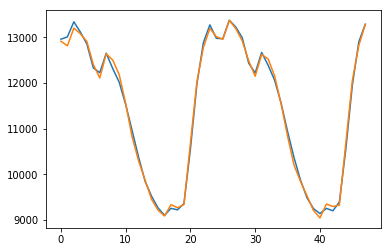

In [86]:
plt.plot(data_actual)
plt.plot(data_predict)

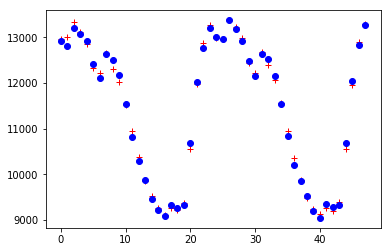

In [90]:
plt.plot(data_actual, 'r+', label='Actual')
plt.plot(data_predict, 'bo', label='Predict')
plt.show()

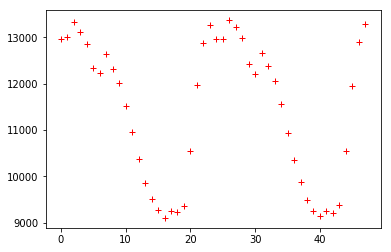

In [62]:
plt.plot(np.array(range(0, hours_needed)), data_actual, 'r+', label='Actual')

### The results have predicted the consecutive hours accurately.